Download specified CycleGAN dataset from a URL and unzip it to a specified directory

In [ ]:
import os
import urllib.request
import zipfile

# create directory if not exist
if not os.path.exists('datasets'):
    os.mkdir('datasets')

# get dataset name as argument
FILE = input("Enter the dataset name: ")

# check if dataset is available
if FILE not in ["ae_photos", "apple2orange", "summer2winter_yosemite", "horse2zebra", "monet2photo", "cezanne2photo", "ukiyoe2photo", "vangogh2photo", "maps", "cityscapes", "facades", "iphone2dslr_flower", "ae_photos"]:
    print("Available datasets are: apple2orange, summer2winter_yosemite, horse2zebra, monet2photo, cezanne2photo, ukiyoe2photo, vangogh2photo, maps, cityscapes, facades, iphone2dslr_flower, ae_photos")
    exit(1)

# download dataset from URL
URL = f"https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/{FILE}.zip"
ZIP_FILE = f"./datasets/{FILE}.zip"
TARGET_DIR = f"./datasets/{FILE}/"
urllib.request.urlretrieve(URL, ZIP_FILE)

# unzip dataset to target directory
with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall(TARGET_DIR)

# remove zip file
os.remove(ZIP_FILE)

Enter the dataset name: apple2orange


Install keras

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Install tensorflow and keras

In [ ]:
!pip install tensorflow==2.7.0
!pip install keras==2.4.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.7/489.7 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 KB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow
    Found

In [ ]:
from os import listdir
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from random import random
from keras.optimizers import Adam

Loads and returns a set of images from a given directory

path: A string representing the directory path where the images are stored
size: A tuple representing the target size of the images. The default value is set to (256, 256)

The function returns the list of loaded images as a numpy array

In [ ]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()

	for filename in listdir(path):
		pixels = load_img(path + filename, target_size=size)
		pixels = img_to_array(pixels)
		data_list.append(pixels)
	return np.asarray(data_list)

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-30tsqbti
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-30tsqbti
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


In [ ]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

Loads image data from the given paths for training and testing sets of domain A and B respectively. Then, it stacks the training and testing sets for domains A and B. The resulting arrays are stored in variables dataA and dataB.

Then we create a compressed NumPy binary file (.npz) with the stacked arrays dataA and dataB and save it in the specified file path using the np.savez_compressed function.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
dataA1 = load_images('/content/datasets/apple2orange/apple2orange/trainA/')
dataAB = load_images('/content/datasets/apple2orange/apple2orange/testA/')
dataA = np.vstack((dataA1, dataAB))
print('Loaded A: ', dataA.shape)

dataB1 = load_images('/content/datasets/apple2orange/apple2orange/trainB/')
dataB2 = load_images('/content/datasets/apple2orange/apple2orange/testB/')
dataB = np.vstack((dataB1, dataB2))
print('Loaded B: ', dataB.shape)

filename = '/content/datasets/apple2orange/apple2orange/apple2orange.npz'
np.savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Loaded A:  (1261, 256, 256, 3)
Loaded B:  (1267, 256, 256, 3)
Saved dataset:  /content/datasets/apple2orange/apple2orange/apple2orange.npz


Discriminator

In [ ]:
from keras.initializers import RandomNormal
import keras
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate

def define_discriminator(image_shape):
	init = RandomNormal(stddev=0.02)
	in_image = keras.Input(shape=image_shape)

	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)

	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)

	# define model
	model = keras.Model(in_image, patch_out)

	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])

	return model

ResNet Block

In [ ]:
def resnet_block(n_filters, input_layer):
	init = RandomNormal(stddev=0.02)

	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)

	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])

	return g

Generator

In [ ]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate
def define_generator(image_shape, n_resnet=9):
	init = RandomNormal(stddev=0.02)
	in_image = keras.Input(shape=image_shape)

	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)

	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)

	# define model
	model = keras.Model(in_image, out_image)

	return model

In [ ]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	g_model_1.trainable = True
	d_model.trainable = False
	g_model_2.trainable = False

	# discriminator 
	input_gen = keras.Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)

	# identity 
	input_id = keras.Input(shape=image_shape)
	output_id = g_model_1(input_id)

	# forward 
	output_f = g_model_2(gen1_out)

	# backward 
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)

	model = keras.Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	opt = Adam(lr=0.0002, beta_1=0.5)

	# loss weights
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[5, 0, 10, 10], optimizer=opt)

	return model

In [ ]:
import numpy as np
def load_real_samples(filename):
  data = np.load(filename)
  X1, X2 = data['arr_0'], data['arr_1']
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5

  return [X1, X2]

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, patch_shape, patch_shape, 1))

	return X, y

In [ ]:
def generate_fake_samples(g_model, dataset, patch_shape):
	X = g_model.predict(dataset)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))

	return X, y

In [ ]:
def save_models(step, g_model_AtoB, g_model_BtoA):
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)

	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)

	print('Saved: %s and %s' % (filename1, filename2))

In [ ]:
from matplotlib import pyplot as plt
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	X_out, _ = generate_fake_samples(g_model, X_in, 0)

	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0

	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_in[i])

	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_out[i])

	filename1 = '%s_generated_plot_%06d.png' % (name, (step + 1))
	plt.savefig(filename1)
	plt.close()

In [ ]:
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			pool.append(image)
			selected.append(image)
		elif random.random() < 0.5:
			selected.append(image)
		else:
			ix = np.random.randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return np.asarray(selected)

In [ ]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	n_epochs, n_batch, = 100, 1
	n_patch = d_model_A.output_shape[1]
	trainA, trainB = dataset
	poolA, poolB = list(), list()
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs
	print('n_steps: ' + str(n_steps))

	# manually enumerate epochs
	for i in range(n_steps):
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)

		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)

		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])

		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])

		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

		print('%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1, dA_loss2, dB_loss1, dB_loss2, g_loss1, g_loss2))

		if i % 50 == 0:
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')

		if i == (n_steps - 1):
			save_models(i, g_model_AtoB, g_model_BtoA)


In [ ]:
dataset = load_real_samples('/content/datasets/apple2orange/apple2orange/apple2orange.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

Loaded (1261, 256, 256, 3) (1267, 256, 256, 3)


In [ ]:
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

# generator: A -> B
g_model_AtoB = define_generator(image_shape)

# generator: B -> A
g_model_BtoA = define_generator(image_shape)

# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)

# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)

# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)

# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

/usr/local/lib/python3.9/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Mar 17 19:39:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    48W / 400W |   9547MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Streaming output truncated to the last 5000 lines.
5088, dA[0.276,0.460] dB[0.064,0.006] g[9.225,5.736]
5089, dA[0.009,0.008] dB[0.006,0.004] g[9.562,7.127]
5090, dA[0.004,0.007] dB[0.004,0.004] g[12.188,11.534]
5091, dA[0.004,0.206] dB[0.052,0.088] g[7.362,6.259]
5092, dA[0.012,0.027] dB[0.002,0.048] g[10.103,10.968]
5093, dA[0.027,0.005] dB[0.005,0.003] g[12.427,11.459]
5094, dA[0.021,0.073] dB[0.027,0.011] g[10.548,7.096]
5095, dA[0.010,0.009] dB[0.060,0.004] g[9.753,7.856]
5096, dA[0.011,0.029] dB[0.005,0.031] g[7.889,7.369]
5097, dA[0.002,0.011] dB[0.003,0.006] g[14.724,15.747]
5098, dA[0.244,0.016] dB[0.004,0.003] g[11.883,13.504]
5099, dA[0.016,0.107] dB[0.004,0.002] g[11.307,8.347]
5100, dA[0.004,0.003] dB[0.002,0.005] g[13.632,13.282]
5101, dA[0.006,0.008] dB[0.004,0.005] g[10.685,11.042]
5102, dA[0.006,0.089] dB[0.003,0.008] g[8.593,6.976]
5103, dA[0.003,0.005] dB[0.005,0.004] g[10.233,11.362]
5104, dA[0.388,0.012] dB[0.007,0.007] g[8.589,9.396]
5105, dA[0.258,0.055] dB[0.007

In [ ]:
from matplotlib import pyplot as plt
from keras.models import load_model
import numpy as np
import random

In [ ]:
dataset = load_real_samples('/content/datasets/iphone2dslr_flower/iphone2dslr_flower/iphone2dslr_flower.npz')

In [ ]:
a, b = dataset
a = (a + 1) / 2.0
b = (b + 1) / 2.0

In [ ]:
from keras.models import load_model
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

# Define the custom layer dictionary
custom_objects = {'InstanceNormalization': InstanceNormalization}

model_AtoB = load_model('g_model_AtoB_012000.h5', custom_objects=custom_objects, compile=False)
model_BtoA = load_model('g_model_BtoA_012000.h5', custom_objects=custom_objects, compile=False)

# Compile the model with the same configuration as before
model_AtoB.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_BtoA.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB_pred = load_model('g_model_AtoB_012000.h5', cust, compile=False)
model_BtoA_pred = load_model('g_model_BtoA_012000.h5', cust, compile=False)

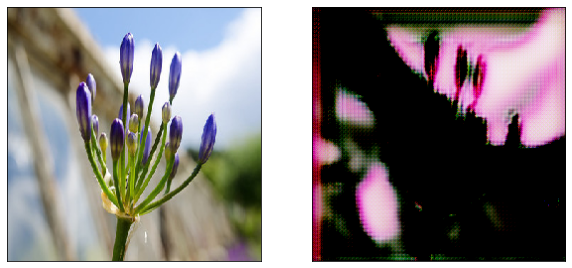

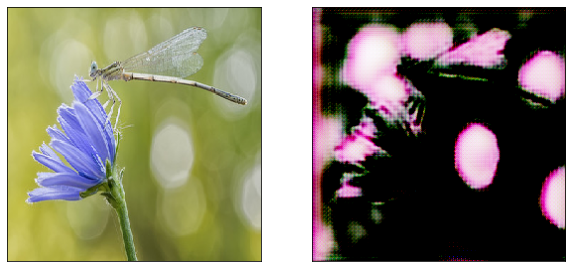

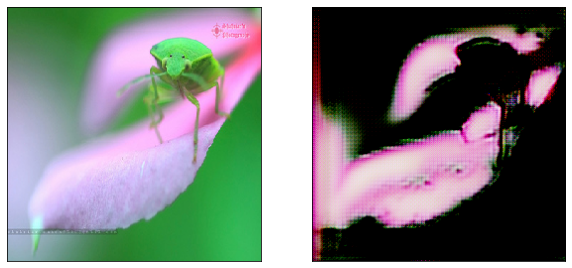

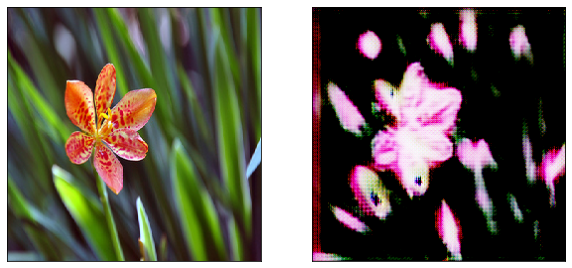

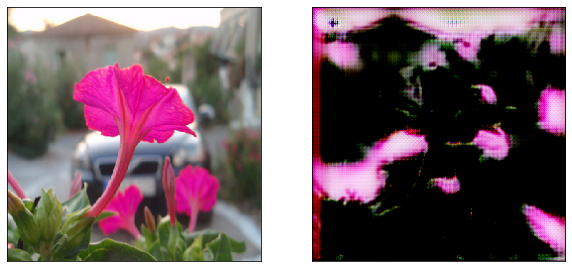

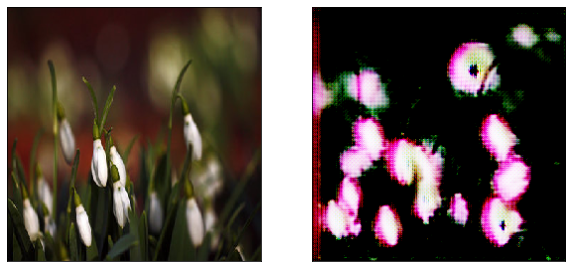

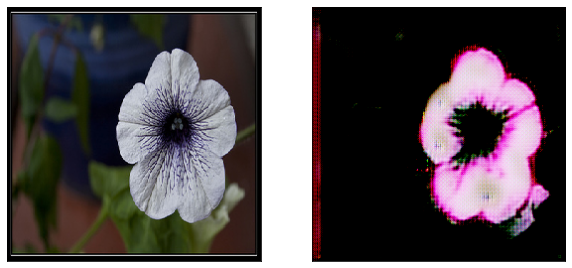

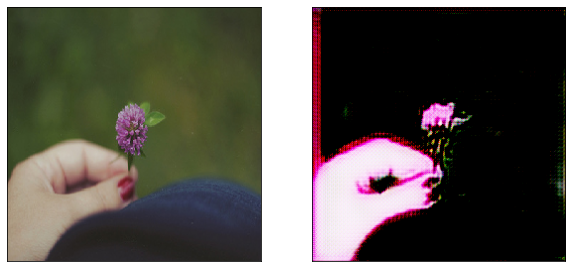

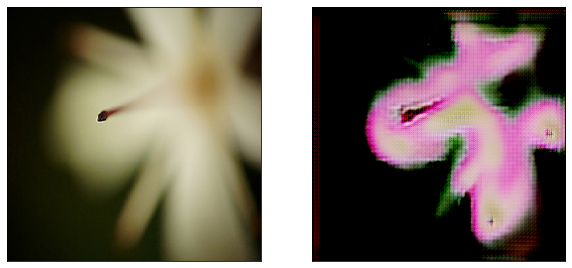

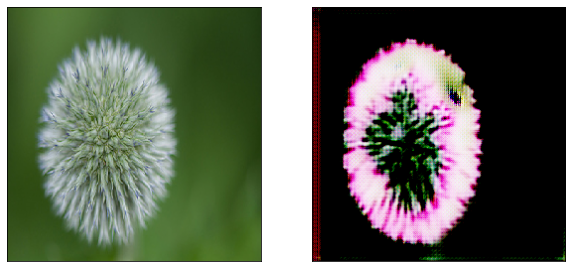

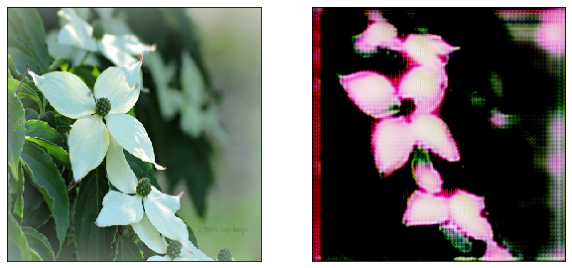

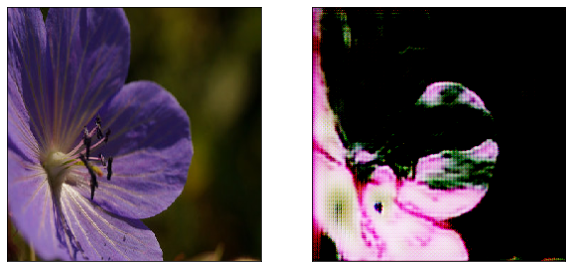

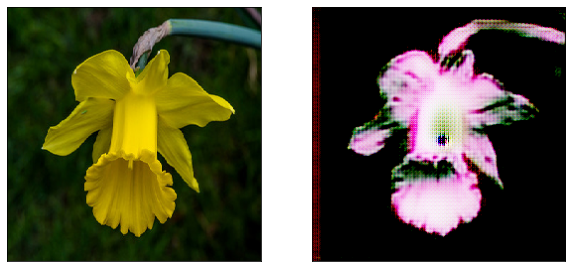

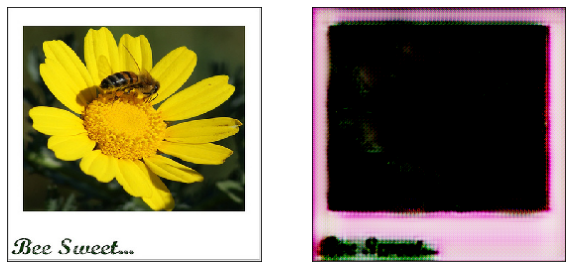

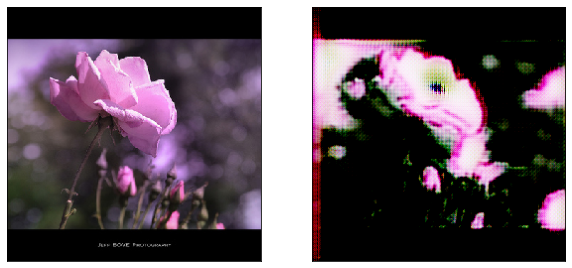

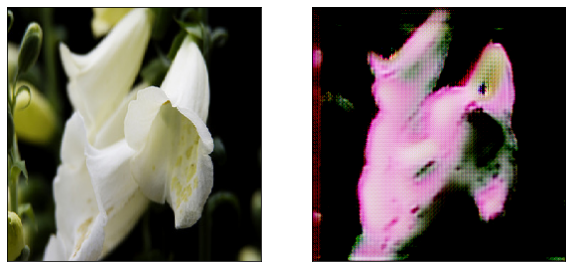

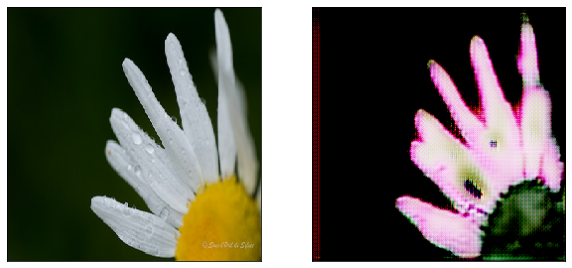

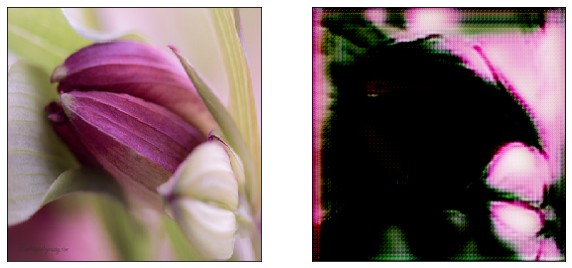

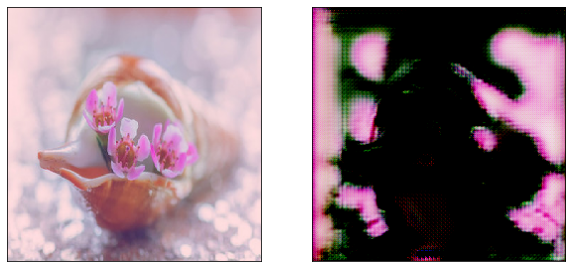

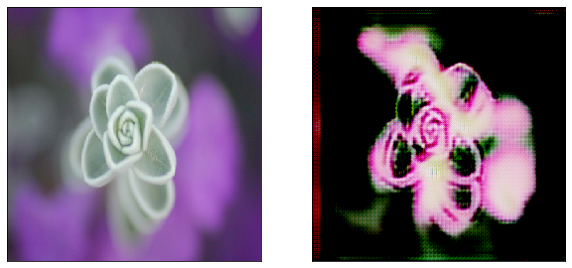

In [ ]:
for i in range(20):
    check = b[i]
    B_generated  = model_BtoA_pred.predict(np.reshape(check, (1, 256, 256, 3)))
    A_reconstructed = model_AtoB_pred.predict(B_generated)

    to_plot = [
      np.reshape(check, (256, 256, 3)), 
      np.reshape(A_reconstructed[0], (256, 256, 3))
    ]

    fig, axes = plt.subplots(1, 2, figsize = (10, 10))
    for i, ax in enumerate(axes.flat):
      to_plot[i] = np.clip(to_plot[i], 0, 1)
      ax.imshow(to_plot[i])
      ax.set_xticks([])
      ax.set_yticks([])

    plt.show()